# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

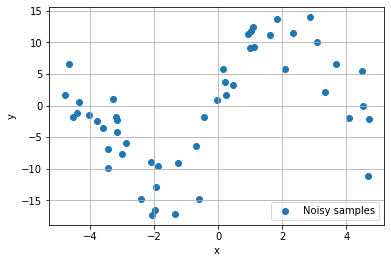

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

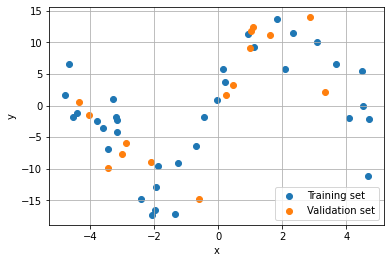

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=150000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=150000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=150000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=150000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

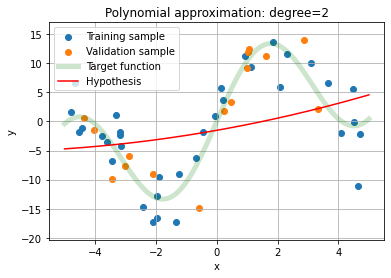

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

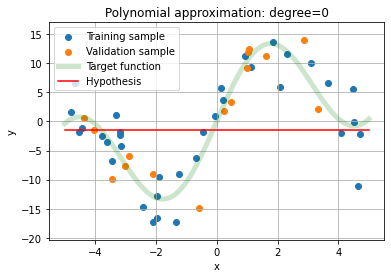

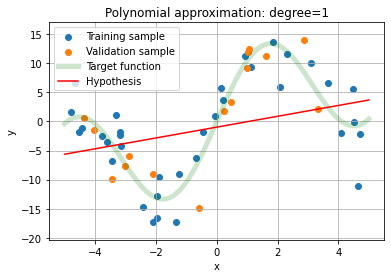

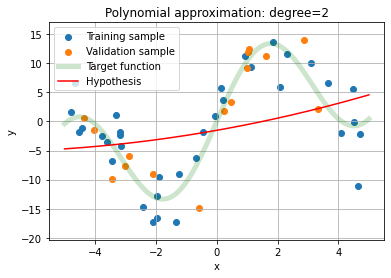

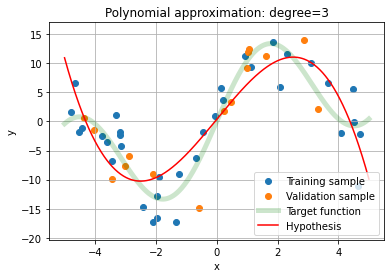

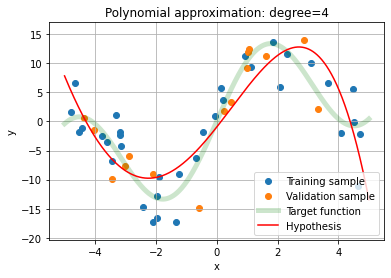

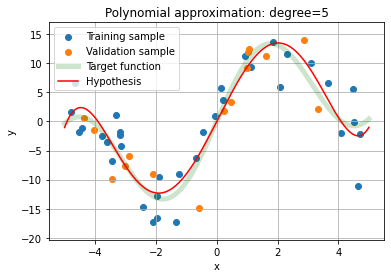

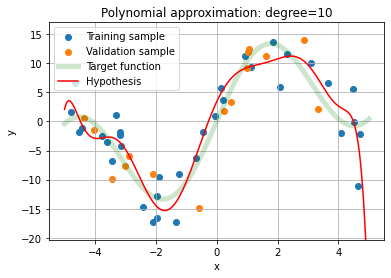

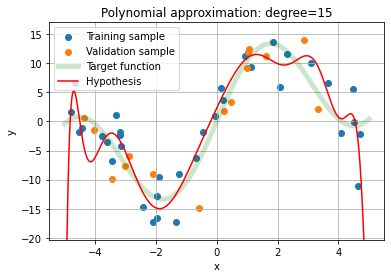

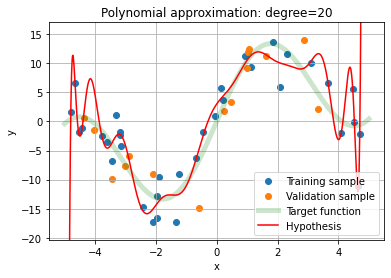

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

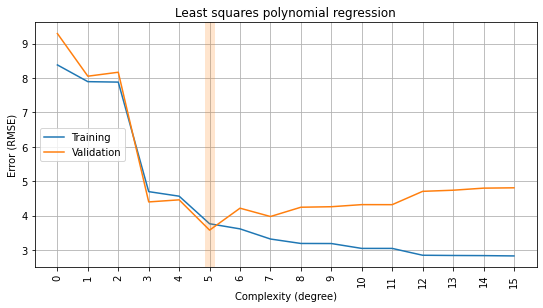

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', 
                       title='Fitting graph', xlim=None, ylim=None):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right') 
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

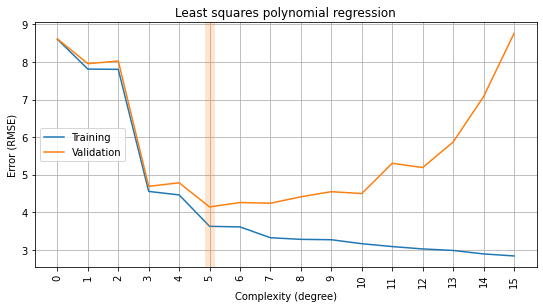

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

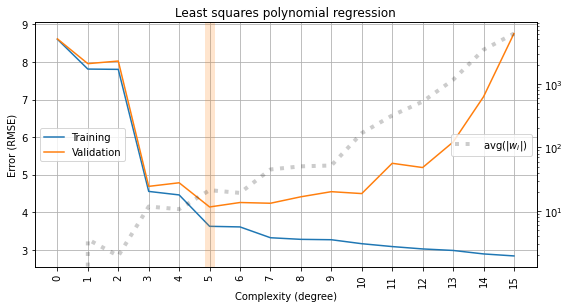

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

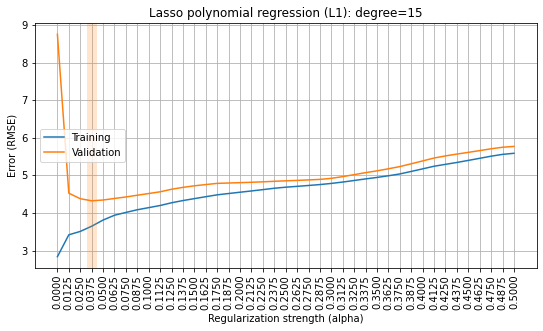

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

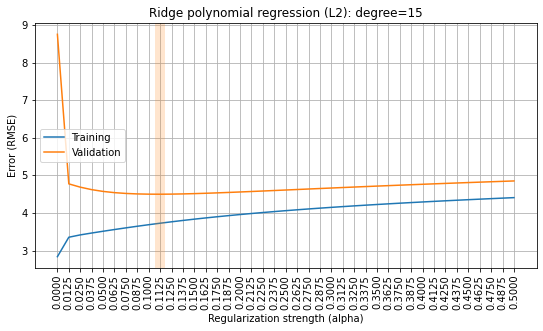

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
df = X_diabetes.copy()
df['target'] = y_diabetes
df.corr()['target'].sort_values(ascending=False).drop(labels='target')

bmi    0.586450
s5     0.565883
bp     0.441482
s4     0.430453
s6     0.382483
s1     0.212022
age    0.187889
s2     0.174054
sex    0.043062
s3    -0.394789
Name: target, dtype: float64

Выберем следующие характеристики: "bmi", "s5", "bp", "s4" и "s6".

In [22]:
def add_poly_features(X, poly_features, degree):
    X.reset_index(drop=True, inplace=True)
    X_poly = PolynomialFeatures(degree=degree, include_bias=(degree==0)).fit_transform(X[poly_features])
    X_new = pd.DataFrame(X_poly)
    other_features = list(set(X.columns) - set(poly_features))
    i = X_poly.shape[1]
    for feature in other_features:
        X_new[i] = X[feature]
        i += 1
    return X_new

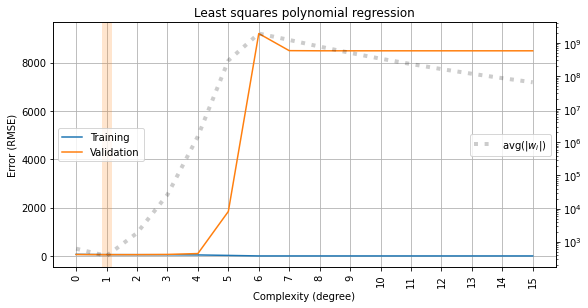

In [23]:
poly_features = ['bmi', 's5', 'bp', 's4', 's6']

model = LinearRegression()
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    X_train_new = add_poly_features(X_train, poly_features, degree)
    X_valid_new = add_poly_features(X_valid, poly_features, degree)
    model.fit(X_train_new, y_train)
    rmse_train.append(rmse(model.predict(X_train_new), y_train))
    rmse_valid.append(rmse(model.predict(X_valid_new), y_valid))        
    avg_coef.append(np.mean([np.mean(np.abs(model.coef_))]))    
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

Лучший результат показан при degree = 1. Есть станный пик при degree = 6, который потом идет на небольшое снижение.

Давайте посмотрим чуть подробнее.

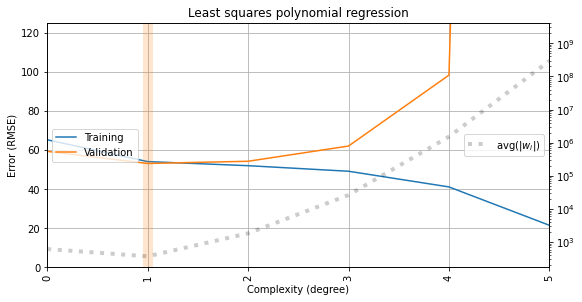

In [24]:
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression', xlim=(0, 5), ylim=(0, 125))

Замтено, что после degree = 1 RMSE начинает расти на тестовых данных. RMSE на тренировачных данных тоже начинает сильнее уменьшаться уже после degree = 4.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

В связи с вычислетильной мощностью моего ноутбука будет выбрана одна характеристика = 'bmi'.

#### L1

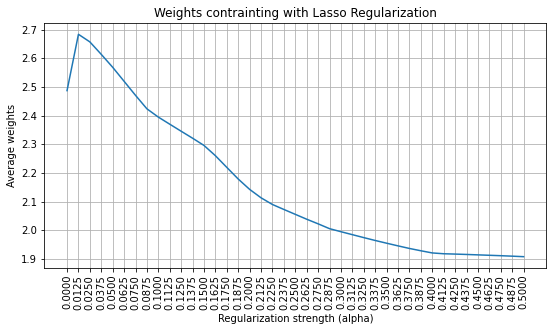

In [25]:
poly_features = ['bmi']
weights_L1 = []

X_new = add_poly_features(X_diabetes, poly_features, degree=15)

for alpha in ALPHAS: 
    results = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha), 
                             X_new, y_diabetes, cv=5,
                             return_estimator=True)
    weights = [model['reg'].coef_ for model in results['estimator']]
    weights_L1.append(np.mean(weights))
    
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, weights_L1, label='average value of weights')
plt.title('Weights contrainting with Lasso Regularization')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Average weights')
plt.xticks(ALPHAS, rotation='vertical')
plt.grid(True)

С увеличением alpha происходит большее ограничение коэффицентов.

#### L2

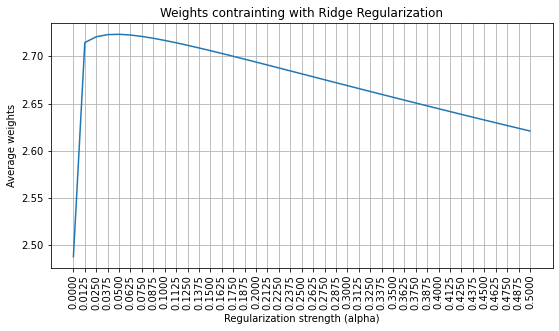

In [26]:
poly_features = ['bmi']
weights_L2 = []

X_new = add_poly_features(X_diabetes, poly_features, degree=15)

for alpha in ALPHAS: 
    results = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha), 
                             X_new, y_diabetes, cv=5,
                             return_estimator=True)
    weights = [model['reg'].coef_ for model in results['estimator']]
    weights_L2.append(np.mean(weights))
    
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, weights_L2, label='average value of weights')
plt.title('Weights contrainting with Ridge Regularization')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Average weights')
plt.xticks(ALPHAS, rotation='vertical')
plt.grid(True)

Здесь наблюдается такая же тенденция

#### Summary

С увеличением alpha происходит большее ограничение коэффицентов, а теперь посмотрим на их минимальные.

In [27]:
print("Minimum average weight with L1: {}", np.mean(weights_L1))
print("Minimum average weight with L2: {}", np.mean(weights_L2))

Minimum average weight with L1: {} 2.1529719612719314
Minimum average weight with L2: {} 2.673580764301201


L1 ограничивает больше.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [28]:
poly_features = ['bmi']
weights_L1 = []

X_new = add_poly_features(X_diabetes, poly_features, degree=15)
X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_diabetes, test_size=0.3, random_state=SEED)

for alpha in ALPHAS[1:]:   
    model = Lasso(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train, y_train)
    weights_L1.append(model.coef_)
    
weights_L1 = np.array(weights_L1)    
df_weights_L1 = pd.DataFrame(data=weights_L1, index=ALPHAS[1:])
df_weights_L1['zeros'] = np.isclose(weights_L1, 0).sum(axis=1)

In [29]:
df_weights_L1['zeros']

0.0125    13
0.0250    15
0.0375    15
0.0500    15
0.0625    15
0.0750    16
0.0875    17
0.1000    17
0.1125    17
0.1250    17
0.1375    17
0.1500    17
0.1625    17
0.1750    18
0.1875    18
0.2000    19
0.2125    19
0.2250    19
0.2375    19
0.2500    19
0.2625    19
0.2750    19
0.2875    19
0.3000    19
0.3125    19
0.3250    19
0.3375    19
0.3500    20
0.3625    20
0.3750    20
0.3875    20
0.4000    20
0.4125    20
0.4250    20
0.4375    20
0.4500    20
0.4625    20
0.4750    20
0.4875    20
0.5000    20
Name: zeros, dtype: int32

Количество нулевых коэффицентов увеличивается, когда alpha становится больше.

#### L2

In [30]:
poly_features = ['bmi']
weights_L2 = []

X_new = add_poly_features(X_diabetes, poly_features, degree=15)
X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_diabetes, test_size=0.3, random_state=SEED)

for alpha in ALPHAS[1:]:   
    model = Ridge(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train, y_train)
    weights_L2.append(model.coef_[0])
    
weights_L2 = np.array(weights_L2)    
df_weights_L2 = pd.DataFrame(data=weights_L2, index=ALPHAS[1:])
df_weights_L2['zeros'] = np.isclose(weights_L2, 0).sum(axis=1)

In [31]:
df_weights_L2['zeros']

0.0125    1
0.0250    1
0.0375    1
0.0500    1
0.0625    1
0.0750    2
0.0875    2
0.1000    2
0.1125    2
0.1250    2
0.1375    2
0.1500    2
0.1625    2
0.1750    2
0.1875    2
0.2000    2
0.2125    2
0.2250    2
0.2375    2
0.2500    2
0.2625    2
0.2750    2
0.2875    2
0.3000    2
0.3125    2
0.3250    2
0.3375    2
0.3500    2
0.3625    2
0.3750    2
0.3875    2
0.4000    2
0.4125    2
0.4250    2
0.4375    2
0.4500    2
0.4625    2
0.4750    2
0.4875    2
0.5000    2
Name: zeros, dtype: int32

Здесь же значительно меньше нулей.

#### Summary

L1 регуляризация имеет большое количество нелувых коэффицентов, чтобы убрать влияение некоторых характеристик. L2 регуляризация подводит коэффиенты к нулю, но практически не делает их такими.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [32]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

C:\Users\dell\AppData\Local\Temp\ipykernel_19940\680603845.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, y_train)
c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.903e+02, tolerance: 1.685e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV ins

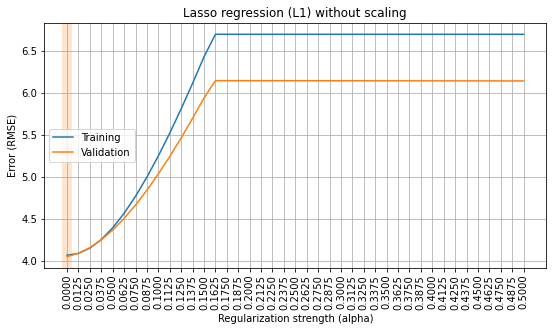

In [33]:
rmse_train, rmse_valid, scores_L1_unscaled = [], [], []

X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

for alpha in ALPHAS:    
    model = Lasso(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train, y_train)
    rmse_train.append(rmse(model.predict(X_train), y_train))
    rmse_valid.append(rmse(model.predict(X_valid), y_valid))
    scores_L1_unscaled.append(model.score(X_valid, y_valid))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso regression (L1) without scaling')

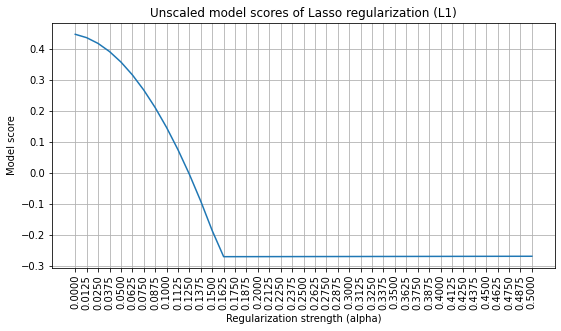

In [34]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, scores_L1_unscaled)
plt.title('Unscaled model scores of Lasso regularization (L1)')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Model score')
plt.xticks(ALPHAS, rotation='vertical')
plt.grid(True)

Оно не только начало уменьшаться, но и стало отрицательного значения.

Теперь попробуем масштабировать значения.

C:\Users\dell\AppData\Local\Temp\ipykernel_19940\3344571277.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, y_train)
c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.807e+00, tolerance: 3.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV i

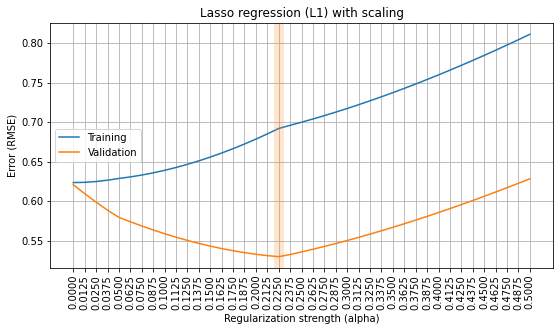

In [35]:
rmse_train, rmse_valid, scores_L1_scaled = [], [], []

scaler_x = StandardScaler()
X_hw_scaled = scaler_x.fit_transform(X_hw)

scaler_y = StandardScaler()
y_hw = y_hw.reshape((-1, 1))
y_hw_scaled = scaler_y.fit_transform(y_hw)

X_train, X_valid, y_train, y_valid = train_test_split(X_hw_scaled, y_hw_scaled, test_size=0.3, random_state=SEED)

for alpha in ALPHAS:    
    model = Lasso(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train, y_train)
    rmse_train.append(rmse(model.predict(X_train), y_train))
    rmse_valid.append(rmse(model.predict(X_valid), y_valid))
    scores_L1_scaled.append(model.score(X_valid, y_valid))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso regression (L1) with scaling')

In [36]:
for i in range(X_hw_scaled.shape[1]):
    print(f'Min of feature {i}: {min(X_hw_scaled[:, i]):.2f}, max: {max(X_hw_scaled[:, i]):.2f}')

Min of feature 0: -1.49, max: 1.83
Min of feature 1: -1.66, max: 1.54
Min of feature 2: -2.14, max: 2.24


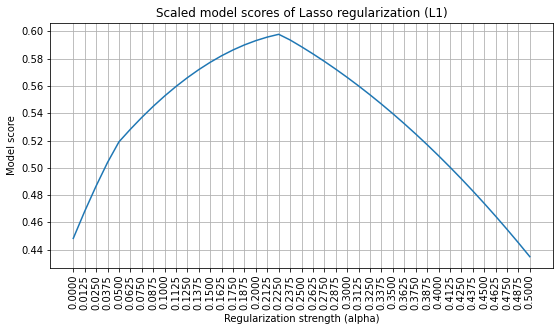

In [37]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, scores_L1_scaled)
plt.title('Scaled model scores of Lasso regularization (L1)')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Model score')
plt.xticks(ALPHAS, rotation='vertical')
plt.grid(True)

Произошло повышение значения score, а потом его уменьшение, но он все равно не становится отрицательным.

#### L2

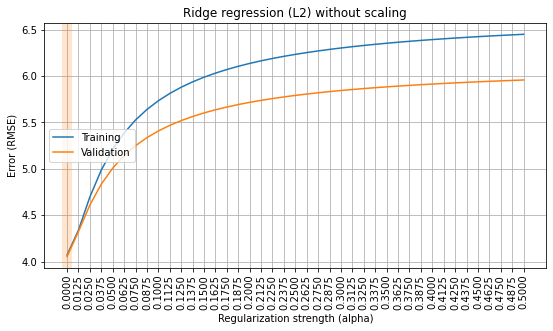

In [38]:
rmse_train, rmse_valid, scores_L2_unscaled = [], [], []

X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

for alpha in ALPHAS:    
    model = Ridge(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train, y_train)
    rmse_train.append(rmse(model.predict(X_train), y_train))
    rmse_valid.append(rmse(model.predict(X_valid), y_valid))
    scores_L2_unscaled.append(model.score(X_valid, y_valid))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge regression (L2) without scaling')

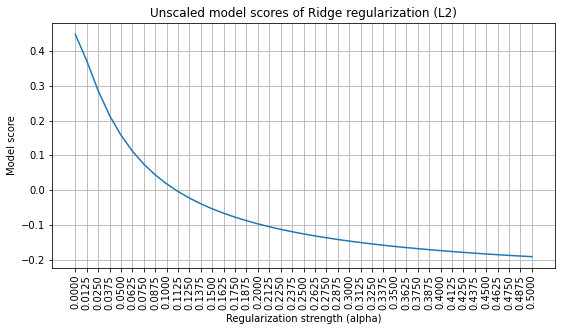

In [39]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, scores_L2_unscaled)
plt.title('Unscaled model scores of Ridge regularization (L2)')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Model score')
plt.xticks(ALPHAS, rotation='vertical')
plt.grid(True)

Ситуация такая же, как и с L1 регуляризацией, но идет более плавно.

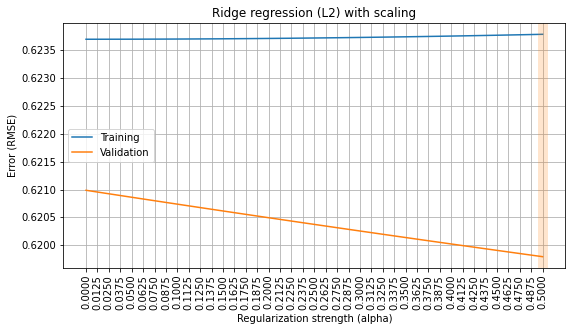

In [40]:
rmse_train, rmse_valid, scores_L2_scaled = [], [], []

scaler_x = StandardScaler()
X_hw_scaled = scaler_x.fit_transform(X_hw)

scaler_y = StandardScaler()
y_hw = y_hw.reshape((-1, 1))
y_hw_scaled = scaler_y.fit_transform(y_hw)

X_train, X_valid, y_train, y_valid = train_test_split(X_hw_scaled, y_hw_scaled, test_size=0.3, random_state=SEED)

for alpha in ALPHAS:    
    model = Ridge(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train, y_train)
    rmse_train.append(rmse(model.predict(X_train), y_train))
    rmse_valid.append(rmse(model.predict(X_valid), y_valid))
    scores_L2_scaled.append(model.score(X_valid, y_valid))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge regression (L2) with scaling')

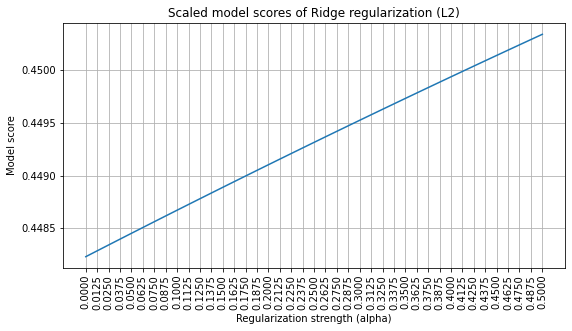

In [41]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, scores_L2_scaled)
plt.title('Scaled model scores of Ridge regularization (L2)')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Model score')
plt.xticks(ALPHAS, rotation='vertical')
plt.grid(True)

Значение score постоянно поднимается, хоть и довольно медленно, но зато не идет вниз и не становится отрицательным.

#### Summary



Если значения не масштабировать, то score уменьшается и может показывать отрицательные значение. Это относится к двум регуляризациям. 